# 概要

遺伝子でない特徴量と遺伝子特徴量を組み合わせてEDAを行う

In [1]:
import math
import numpy as np
import pandas as pd
import tqdm

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

# draw KM line
from lifelines import KaplanMeierFitter, CoxPHFitter

# config python file\\
import config
import functions

functions.fix_seed(config.SEED)

# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)

# %matplotlib inline

/home/breast-cancer-analytics/notebooks/functions.py:185: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_train: pd.Series(),
/home/breast-cancer-analytics/notebooks/functions.py:187: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_val: pd.Series(),


# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [3]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
# check(df_clinical)
df_clinical.shape

(2509, 36)

## カラムの順序変更（読みやすさのため）

In [4]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    _df = df.copy()
    df_tmp = _df.filter(regex=regex)
    # 元のdfから落とす
    _df.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(_df, df_tmp, right_index=True, left_index=True)


def sort_columns_by_knowledge(df):
    _df = df.copy()
    # 癌の種類
    _df = align_columns(_df, "^CANCER_")
    # 重要そう（直感）な特徴量
    _df = align_columns(_df, "^ER_|^HER2_|^TUMOR_")
    # 治療の種類
    _df = align_columns(_df, ".*THERAPY$|^BREAST_SURGERY")
    # target系の種類（OS, RFS, VITAL）
    _df = align_columns(_df, "^OS_.*|^RFS_.*|^VITAL_.*")
    return _df


df_clinical = sort_columns_by_knowledge(df_clinical)

In [5]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]

df_MB.set_index("PATIENT_ID", inplace=True)
df_MTST.set_index("PATIENT_ID", inplace=True)

display(df_MB.shape, df_MTST.shape)
# save
functions.make_dir(config.INTERIM_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_EDA_DIR + "/df_MTST.pkl")
del df_patient, df_sample, df_clinical, df_MB, df_MTST

(1985, 35)

(524, 35)

## 臨床データの読み込み

In [6]:
df_MB = pd.read_pickle(config.INTERIM_EDA_DIR + "/df_MB.pkl")

## 遺伝子データの読み込み

In [7]:
# 遺伝子発現データ
# 生の遺伝子発現データ
df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop(
    "Entrez_Gene_Id"
).sort_index()
"""
# zスコア化済み
df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
).sort_index()
"""

"""
# zスコア化（2倍体基準）済み
df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
).sort_index()

# cnaデータ
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T.sort_index()
"""
pass

# 臨床データのEDA

## 各特徴毎の再発期間の確認

サブグループ毎に再発した患者の割合・晩年再発・カプランマイヤー曲線を確認する

In [8]:
# functions.check(df_MB)

In [9]:
df_MB.dropna(subset="RFS_STATUS", inplace=True)

### recurrence patient num

In [10]:
df_MB.RFS_STATUS.value_counts()

0:Not Recurred    1180
1:Recurred         804
Name: RFS_STATUS, dtype: int64

In [11]:
df_MB[df_MB["RFS_STATUS"] == "1:Recurred"].groupby("CLAUDIN_SUBTYPE").count()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
CLAUDIN_SUBTYPE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Basal,88,93,92,93,93,93,93,93,74,82,91,93,93,93,93,93,93,93,93,92,93,93,93,91,66,93,93,93,88,93,93,93,93,93
Her2,114,116,110,116,116,116,116,116,98,106,115,116,111,116,116,116,116,116,116,115,116,116,116,114,78,116,116,116,115,116,116,116,116,116
LumA,222,231,227,231,231,231,231,231,220,226,227,231,218,231,231,231,231,231,231,231,231,231,231,231,184,231,231,231,229,231,231,231,231,231
LumB,220,227,226,227,227,227,227,227,196,212,225,227,219,227,227,227,227,227,227,222,227,227,227,225,168,227,227,227,226,227,227,227,227,227
NC,3,3,3,3,3,3,3,3,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,3,3,3,3,3,3,3,3,3
Normal,61,65,57,65,65,65,65,65,59,62,64,65,63,65,65,65,65,65,65,65,65,65,65,65,50,65,65,65,65,65,65,65,65,65
claudin-low,63,68,67,68,68,68,68,68,56,60,66,68,65,68,68,68,68,68,68,64,68,68,68,65,57,68,68,68,67,68,68,68,68,68


In [12]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] <= 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count().iloc[0]

LYMPH_NODES_EXAMINED_POSITIVE    80
NPI                              84
CELLULARITY                      84
COHORT                           84
INFERRED_MENOPAUSAL_STATE        84
SEX                              84
INTCLUST                         84
AGE_AT_DIAGNOSIS                 84
THREEGENE                        68
LATERALITY                       73
HISTOLOGICAL_SUBTYPE             82
SAMPLE_ID                        84
GRADE                            84
ONCOTREE_CODE                    84
PR_STATUS                        84
SAMPLE_TYPE                      84
TMB_NONSYNONYMOUS                84
CANCER_TYPE                      84
CANCER_TYPE_DETAILED             84
ER_IHC                           84
HER2_SNP6                        84
ER_STATUS                        84
HER2_STATUS                      84
TUMOR_SIZE                       82
TUMOR_STAGE                      58
CHEMOTHERAPY                     84
HORMONE_THERAPY                  84
RADIO_THERAPY               

In [13]:
df_MB[(df_MB["RFS_STATUS"] == "1:Recurred") & (df_MB["RFS_MONTHS"] > 5 * 12)].groupby(
    "CLAUDIN_SUBTYPE"
).count().iloc[0]

LYMPH_NODES_EXAMINED_POSITIVE    8
NPI                              9
CELLULARITY                      8
COHORT                           9
INFERRED_MENOPAUSAL_STATE        9
SEX                              9
INTCLUST                         9
AGE_AT_DIAGNOSIS                 9
THREEGENE                        6
LATERALITY                       9
HISTOLOGICAL_SUBTYPE             9
SAMPLE_ID                        9
GRADE                            9
ONCOTREE_CODE                    9
PR_STATUS                        9
SAMPLE_TYPE                      9
TMB_NONSYNONYMOUS                9
CANCER_TYPE                      9
CANCER_TYPE_DETAILED             9
ER_IHC                           8
HER2_SNP6                        9
ER_STATUS                        9
HER2_STATUS                      9
TUMOR_SIZE                       9
TUMOR_STAGE                      8
CHEMOTHERAPY                     9
HORMONE_THERAPY                  9
RADIO_THERAPY                    9
BREAST_SURGERY      

we need to sqweeze our data by RFS MONTHS>=5*12 or not

<AxesSubplot: >

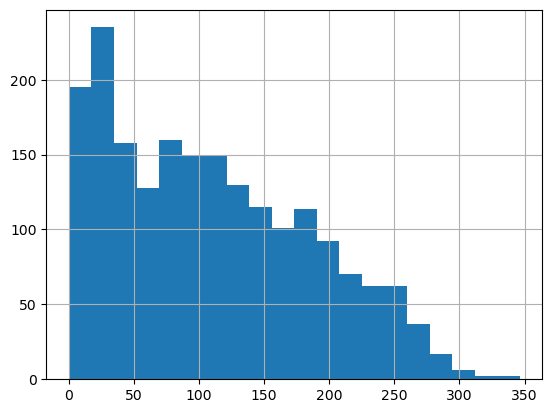

In [14]:
%matplotlib inline
df_MB.RFS_MONTHS.hist(bins=20)

<AxesSubplot: xlabel='PATIENT_ID'>

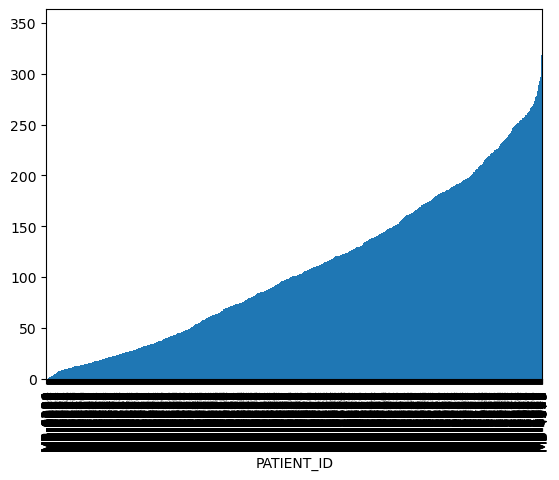

In [145]:
# 全体の再発率プロット
df_MB.sort_values("RFS_MONTHS")["RFS_MONTHS"].plot.bar()

<AxesSubplot: xlabel='RFS_STATUS', ylabel='RFS_MONTHS'>

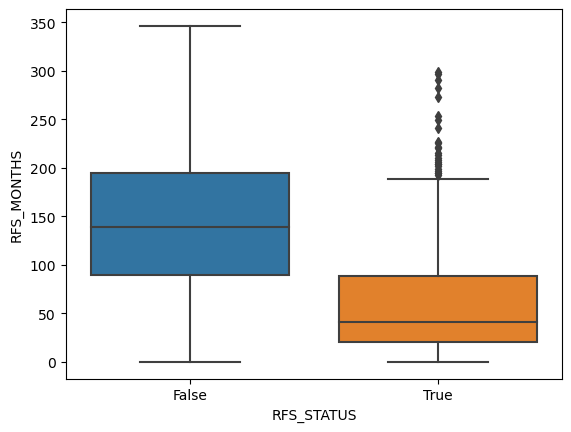

In [149]:
# 再発の有無でのプロット
sns.boxplot(data=df_MB, x="RFS_STATUS", y="RFS_MONTHS")

In [150]:
df_MB[df_MB.RFS_MONTHS < 1]

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,COHORT,INFERRED_MENOPAUSAL_STATE,SEX,INTCLUST,AGE_AT_DIAGNOSIS,CLAUDIN_SUBTYPE,THREEGENE,LATERALITY,HISTOLOGICAL_SUBTYPE,SAMPLE_ID,GRADE,ONCOTREE_CODE,PR_STATUS,SAMPLE_TYPE,TMB_NONSYNONYMOUS,CANCER_TYPE,CANCER_TYPE_DETAILED,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,TUMOR_STAGE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,BREAST_SURGERY,OS_MONTHS,OS_STATUS,VITAL_STATUS,RFS_STATUS,RFS_MONTHS
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MB-0284,0.0,1.000,Moderate,1.0,Post,Female,10,51.42,claudin-low,ER-/HER2-,NaN,Ductal/NST,MB-0284,NaN,IDC,Negative,Primary,2.615035,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,NEUTRAL,Negative,Negative,NaN,NaN,NO,NO,NO,NaN,0.000000,0:LIVING,Living,False,0.00
MB-0627,0.0,5.040,Moderate,1.0,Post,Female,4ER-,54.10,claudin-low,ER-/HER2-,Right,Ductal/NST,MB-0627,3.0,IDC,Negative,Primary,3.922553,Breast Cancer,Breast Invasive Ductal Carcinoma,Negative,NEUTRAL,Negative,Negative,20.0,NaN,NO,NO,NO,MASTECTOMY,0.766667,0:LIVING,Living,False,0.76
MB-5311,0.0,3.054,High,3.0,Post,Female,4ER+,73.01,claudin-low,ER-/HER2-,Right,Ductal/NST,MB-5311,2.0,IDC,Positive,Primary,10.460142,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,27.0,2.0,NO,YES,YES,BREAST CONSERVING,57.666667,1:DECEASED,Died of Disease,True,0.69
MB-5520,4.0,6.050,High,3.0,Pre,Female,7,38.49,LumA,ER+/HER2- High Prolif,Left,Mixed,MB-5520,3.0,MDLC,Negative,Primary,6.537589,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Positve,NEUTRAL,Positive,Negative,25.0,2.0,NO,YES,NO,MASTECTOMY,16.300000,1:DECEASED,Died of Disease,True,0.82
MB-6063,16.0,6.240,High,5.0,Post,Female,5,58.90,Normal,HER2+,Left,Ductal/NST,MB-6063,3.0,IDC,Negative,Primary,2.615035,Breast Cancer,Breast Invasive Ductal Carcinoma,Negative,GAIN,Negative,Positive,120.0,NaN,YES,NO,NO,MASTECTOMY,15.600000,1:DECEASED,Died of Disease,True,0.36
MB-6098,1.0,5.160,High,5.0,Pre,Female,10,28.29,Basal,NaN,Left,Ductal/NST,MB-6098,3.0,IDC,Negative,Primary,7.845106,Breast Cancer,Breast Invasive Ductal Carcinoma,Negative,NEUTRAL,Negative,Negative,80.0,NaN,YES,NO,NO,MASTECTOMY,10.633333,1:DECEASED,Died of Disease,True,0.69
MB-6194,9.0,5.050,High,5.0,Pre,Female,4ER-,44.51,Normal,ER+/HER2- Low Prolif,Left,Mixed,MB-6194,2.0,MDLC,Positive,Primary,10.460142,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Negative,NEUTRAL,Negative,Negative,25.0,2.0,YES,NO,YES,MASTECTOMY,52.466667,1:DECEASED,Died of Disease,True,0.00
MB-6229,0.0,2.030,High,5.0,Post,Female,8,75.33,LumA,ER+/HER2- Low Prolif,Right,Ductal/NST,MB-6229,1.0,IDC,Positive,Primary,6.537589,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,15.0,1.0,NO,NO,NO,MASTECTOMY,0.100000,1:DECEASED,Died of Disease,True,0.10
MB-6230,NaN,5.042,High,5.0,Post,Female,3,52.95,LumA,NaN,Left,Ductal/NST,MB-6230,2.0,IDC,Positive,Primary,0.000000,Breast Cancer,Breast Invasive Ductal Carcinoma,Positve,NEUTRAL,Positive,Negative,21.0,NaN,NO,YES,NO,MASTECTOMY,74.800000,1:DECEASED,Died of Disease,True,0.00


In [15]:
df_MB[df_MB.RFS_MONTHS > 5 * 12].shape

(1340, 35)

## 全体の再発期間のばらつき

In [16]:
year = 5
df_tmp = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
print("survived > 60 months (not recurred): ", (df_tmp.RFS_MONTHS > 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print("RFS MONTHS <= 60 months (recurred): ", (df_tmp.RFS_MONTHS <= 12 * year).sum())
df_tmp = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
print("RFS MONTHS > 12 (recurred): ", (df_tmp.RFS_MONTHS > 12 * year).sum())

del df_tmp

survived > 60 months (not recurred):  1031
RFS MONTHS <= 60 months (recurred):  495
RFS MONTHS > 12 (recurred):  309


### 分布ヒストグラム

In [17]:
plt.figure(figsize=(4, 4))

df_MB.RFS_MONTHS.hist(bins=int(math.log2(df_MB.shape[0])), label="all data")

df_plot = df_MB[df_MB.RFS_STATUS == "0:Not Recurred"]
df_plot.RFS_MONTHS.hist(bins=int(math.log2(df_plot.shape[0])), label="0:Not Reccured")
df_plot = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
df_plot.RFS_MONTHS.hist(bins=int(math.log2(df_plot.shape[0])), label="1:Recurred")

plt.legend()
plt.title("RFS MONTHS")
plt.ylabel("num")
plt.xlabel("months")
plt.plot()
del df_plot

0:Not Reccured -> 初診から最終フォローアップまでの期間なので注意

<BarContainer object of 5 artists>

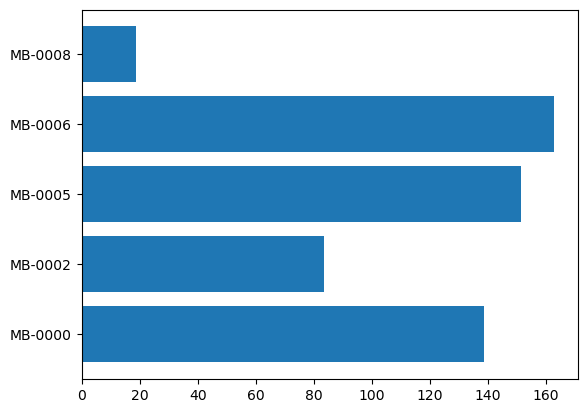

In [34]:
plt.barh(y=df_MB.head().index, width=df_MB.RFS_MONTHS.head())

### KM lineの描画
全体の再発期間の可視化のためにカプランマイヤー曲線を描画

**打ち切り**
右側打ち切り：再発なし患者  
左側打ち切り：なし（今回のデータでは初診からすでに再発している患者がいるか不明なため）  

**注意点**
RFS_MONTHSは再発者であれば初診～再発の期間を示すが、非再発者であれば初診から最終フォローアップまでの期間を示している。  

In [18]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()

df_plot = df_MB[["RFS_MONTHS", "RFS_STATUS"]]
df_plot = df_plot.replace({"0:Not Recurred": False, "1:Recurred": True})
kmf = KaplanMeierFitter()
kmf.fit(durations=df_plot.RFS_MONTHS, event_observed=df_plot.RFS_STATUS)
kmf.plot()

ax.set_xlabel("RFS_MONTHS")
ax.set_ylabel("RECURRENCE PATIENT RATE")
ax.axvline(5 * 12)
ax.axvline(10 * 12)
ax.axvline(15 * 12)
plt.xlim(0, 350)
plt.ylim(0, 1.0)
plt.show()

del df_plot

In [19]:
def EDA_subgroup_relations(
    subgroup_name: str, thresholt_year: int = year, print_ratio=False
):
    # 統計情報
    if print_ratio:
        print("欠損値数：", df_MB[subgroup_name].isna().sum())
        df_recurred = df_MB[df_MB.RFS_STATUS == "1:Recurred"]
        print("再発者/全患者")
        print(
            df_recurred[subgroup_name].value_counts()
            / df_MB[subgroup_name].value_counts()
        )
        print("{0}年以内再発者/全再発者".format(thresholt_year))
        print(
            df_recurred[df_recurred.RFS_MONTHS <= 12 * thresholt_year][
                subgroup_name
            ].value_counts()
            / df_recurred[subgroup_name].value_counts()
        )
        print("{0}年以後再発者/全再発者".format(thresholt_year))
        print(
            df_recurred[df_recurred.RFS_MONTHS > 12 * thresholt_year][
                subgroup_name
            ].value_counts()
            / df_recurred[subgroup_name].value_counts()
        )

    # カプランマイヤー曲線可視化

    for subgroup in df_MB[subgroup_name].unique():
        if type(subgroup) != str:
            continue
        df_subgroup = df_MB[df_MB[subgroup_name] == subgroup][
            ["RFS_MONTHS", "RFS_STATUS"]
        ]
        df_subgroup = df_subgroup.replace({"0:Not Recurred": False, "1:Recurred": True})
        kmf = KaplanMeierFitter()
        kmf.fit(
            durations=df_subgroup.RFS_MONTHS,
            event_observed=df_subgroup.RFS_STATUS,
            label=subgroup,
        )
        kmf.plot(ci_show=False)
    plt.xlabel("RFS_MONTHS")
    plt.ylabel("RECURRENCE PATIENT RATE")
    plt.axvline(5 * 12)
    plt.axvline(10 * 12)
    plt.axvline(15 * 12)
    plt.title(subgroup_name)
    plt.xlim(0, 350)
    plt.ylim(0, 1.0)
    del df_subgroup

## サブグループの特徴がカテゴリ変数の場合

### CLAUDIN_SUBTYPE

注目したい要因

In [20]:
EDA_subgroup_relations("CLAUDIN_SUBTYPE")

### その他の要因（注目度低）

In [21]:
columns = [
    "ONCOTREE_CODE",
    "ER_STATUS",
    "ER_IHC",
    "HER2_STATUS",
    "HER2_SNP6",
    "PR_STATUS",
    "THREEGENE",
    "HISTOLOGICAL_SUBTYPE",
    "HORMONE_THERAPY",
    "RADIO_THERAPY",
    "BREAST_SURGERY",
    "CHEMOTHERAPY",
]

plt.figure(figsize=(24, 18))
for i, column in enumerate(columns):
    plt.subplot(3, 4, i + 1)
    EDA_subgroup_relations(column)
plt.show()

## サブグループの特徴が数値データの場合（カテゴリ化する必要がある）

### NPI
ノッティンガムの予後指数：https://en.wikipedia.org/wiki/Nottingham_Prognostic_Index  

### 腫瘍サイズ

乳癌のステージの定義：https://oshiete-gan.jp/breast/diagnosis/stages/detail.html

腫瘍サイズ0mm/20mm/50mmで区切るのがよさそう？

### リンパ節陽性数

層別化ソース：https://medical.nikkeibp.co.jp/leaf/all/cancernavi/news/201403/535575.html

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
print("#NPI")
print("欠損値数：", df_MB.NPI.isna().sum())
print("最小値：", df_MB.NPI.min(), " 最大値：", df_MB.NPI.max())
plt.xlim(1, int(df_MB.NPI.max() + 1))
plt.title("NPI")
df_MB.NPI.hist(bins=int(math.log2(df_MB.shape[0])))

plt.subplot(1, 3, 2)
print("#TUMOR_SIZE")
print("欠損値数：", df_MB.TUMOR_SIZE.isna().sum())
print("最小値：", df_MB.TUMOR_SIZE.min(), " 最大値：", df_MB.TUMOR_SIZE.max())
plt.title("TUMOR_SIZE")
df_MB.TUMOR_SIZE.hist(bins=int(math.log2(df_MB.shape[0])))

plt.subplot(1, 3, 3)
print("#LYMPH_NODES_EXAMINED_POSITIVE")
print("欠損値数：", df_MB.LYMPH_NODES_EXAMINED_POSITIVE.isna().sum())
print(
    "最小値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.min(),
    " 最大値：",
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE.max(),
)
print(
    "1/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.25),
    " 1/2分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.5),
    " 3/4分位点：",
    df_MB["LYMPH_NODES_EXAMINED_POSITIVE"].quantile(0.75),
)
plt.title("LYMPH_NODES_EXAMINED_POSITIVE")
df_MB.LYMPH_NODES_EXAMINED_POSITIVE.hist(bins=int(math.log2(df_MB.shape[0])))
plt.show()

In [23]:
df_MB["NPI_CAT"] = pd.cut(
    df_MB.NPI,
    [0, 2.0, 2.4, 3.4, 5.4, np.inf],
    labels=["0.0~2.0", "2.0~2.4", "2.4~3.4", "3.4~5.4", "5.4~inf"],
)


df_MB["TUMOR_CAT"] = pd.cut(
    df_MB.TUMOR_SIZE, [0, 20, 50, np.inf], labels=["0~20", "20~50", "50~inf"]
)

df_MB["LYMPH_CAT"] = pd.cut(
    df_MB.LYMPH_NODES_EXAMINED_POSITIVE,
    [-np.inf, 0, 3, np.inf],
    labels=["0", "1~3", "4~inf"],
)


plt.figure(figsize=(12, 4))
columns = ["NPI_CAT", "TUMOR_CAT", "LYMPH_CAT"]
for i, column in enumerate(columns):
    plt.subplot(1, 3, i + 1)
    EDA_subgroup_relations(column)
plt.show()

### その他の要因（注目度低）

欠損値数： 88
最小値： 1.0  最大値： 3.0


<AxesSubplot: >

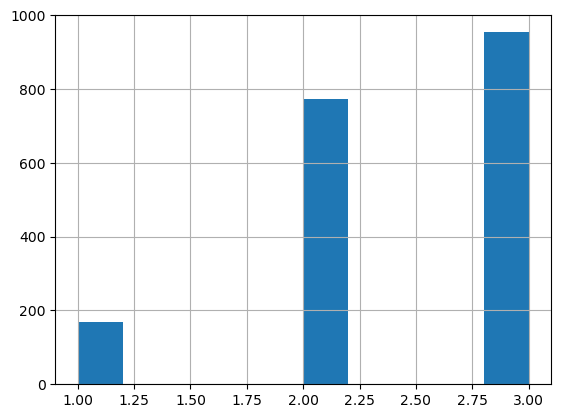

In [24]:
print("欠損値数：", df_MB.GRADE.isna().sum())
print(
    "最小値：",
    df_MB.GRADE.min(),
    " 最大値：",
    df_MB.GRADE.max(),
)
df_MB.GRADE.hist(bins=int(math.log2(df_MB.shape[0])))

In [25]:
df_MB["GRADE_CAT"] = pd.cut(
    df_MB.GRADE,
    [0, 1, 2, 3],
    labels=[
        "1",
        "2",
        "3",
    ],
)

df_MB["TMB_CAT"] = pd.qcut(
    df_MB.TMB_NONSYNONYMOUS, [0, 0.1, 0.9, 1], labels=["c1", "c2", "c3"]
)

plt.figure(figsize=(8, 4))
columns = ["GRADE_CAT", "TMB_CAT"]
for i, column in enumerate(columns):
    plt.subplot(1, 2, i + 1)
    EDA_subgroup_relations(column)
plt.show()

# 遺伝子発現量データのEDA

## 各マイクロアレイ手法毎の確認

mrna_agilent_microarrayとmrna_agilent_microarray_zscores_ref_all_samplesの遺伝子は完全に一致しているが、mrna_agilent_microarray_zscores_ref_diploid_samplesはそれら2つとは違う（特徴量数が不足している）ことを確認済み

# 再発者のみのデータのEDA

2-preprocess_RFSノートブックから、前処理をして再発者に限定したdf: df_recurrencedを取り出す

In [26]:
# 臨床データ（層別化対象）と遺伝子データが結合されており、再発者に限定されている

df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)
df_recurrenced = pd.merge(
    df_MB["RFS_MONTHS"], df_recurrenced, right_index=True, left_index=True
)

## 再発までの期間と遺伝子発現量の相関の確認

実行時間がかかるので注意

In [27]:
drop_columns = [
    "RFS_OVER_60MONTHS",
    "CLAUDIN_SUBTYPE",
    "NPI_CAT",
    "TUMOR_CAT",
    "LYMPH_CAT",
]

# 前処理後の再発者に限定した患者の、各遺伝子と再発までの期間の相関係数
# ※非再発者は再発期間がないので見ていない

"""
corr = pd.merge(
    df_recurrenced.drop(drop_columns, axis=1), df_MB.RFS_MONTHS, left_index=True, right_index=True
).corr()
corr["RFS_MONTHS"].drop("RFS_MONTHS").sort_values(ascending=False).hist()
"""
pass

生の遺伝子発現量情報のみでは相関は見られない（目安：0.5以上ぐらいが相関があると考えられている）

# クラスタリング

遺伝子発現量数が多いが、削除してしまうと候補の対象外となってしまう→クラスターで特徴量数を削減した上で、代表値と再発期間の関連を見る

参考
- https://qiita.com/Hatomugi/items/d6c8bb1a049d3a84feaa
- https://qiita.com/g-k/items/120f1cf85ff2ceae4aba


## PCA
 
特徴量から平均を引く（センタリング）ことは必須  
しかし、標準偏差で割る（標準化する）ことについては議論があるとのこと
https://qiita.com/koshian2/items/2e69cb4981ae8fbd3bda

In [28]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats


# 再発期間の数値情報
df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced.pkl"
)
df_recurrenced = pd.merge(
    df_MB["RFS_MONTHS"], df_recurrenced, right_index=True, left_index=True
)

# 特徴量のセンタリング
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_center = df_recurrenced[df_gene_expressions.columns] - df_recurrenced[
    df_gene_expressions.columns
].mean(axis=0)

# pca
pca = PCA(n_components=0.95, random_state=config.SEED)
pca.fit(df_center)
reduced_data = pca.transform(df_center)

plot

            0
0    0.106613
1    0.083806
2    0.054757
3    0.033022
4    0.030441
..        ...
522  0.000284
523  0.000284
524  0.000282
525  0.000281
526  0.000281

[527 rows x 1 columns]
pcaによって説明分散比の95%を保持するクラスターの数:  527


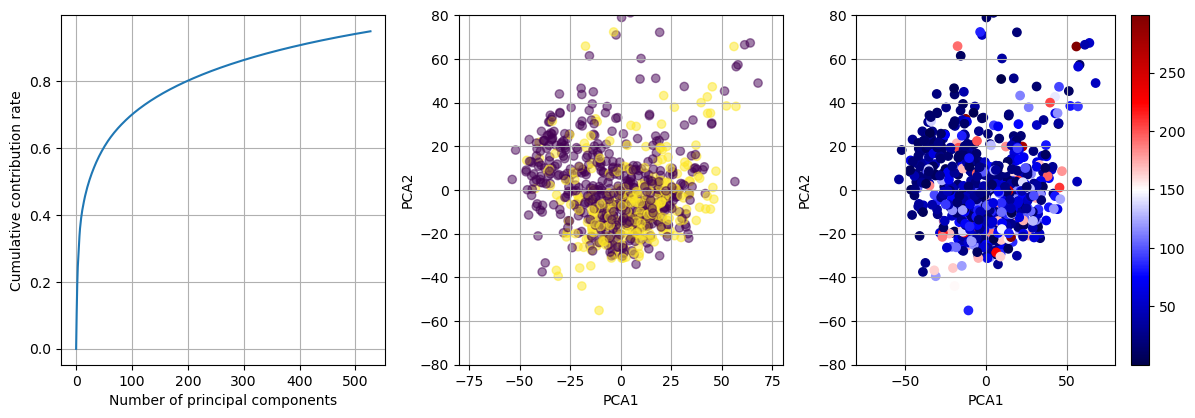

In [29]:
plt.figure(figsize=(12, 12))

# pcaで削減された後に残る情報量の推移の可視化
plt.subplot(331)
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative contribution rate")
plt.grid()
plt.plot([0] + list(np.cumsum(pca.explained_variance_ratio_)), "-")
print("pcaによって説明分散比の95%を保持するクラスターの数: ", pca.n_components_)


# pcaの前段階で標準化していないので、正直可視化しないほうが良い（ミスリードに繋がる）
# 2次元まで落とし込んだときの散布図（目的変数で色分け）
plt.subplot(332)
plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    alpha=0.5,
    c=list(df_recurrenced["RFS_OVER_60MONTHS"]),
)
plt.grid()
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.xlim(-80, 80)
plt.ylim(-80, 80)


import matplotlib.cm as cm


plt.subplot(333)
sc = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=df_recurrenced["RFS_MONTHS"],
    cmap=cm.seismic,
)
plt.grid()
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.xlim(-80, 80)
plt.ylim(-80, 80)
plt.tight_layout()
plt.colorbar(sc)
plt.show()

,pca0,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca9,pca10,pca11,pca12,pca13,pca14,pca15,pca16,pca17,pca18,pca19,pca20,pca21,pca22,pca23,pca24,...,pca502,pca503,pca504,pca505,pca506,pca507,pca508,pca509,pca510,pca511,pca512,pca513,pca514,pca515,pca516,pca517,pca518,pca519,pca520,pca521,pca522,pca523,pca524,pca525,pca526
MB-0005,-19.210907,-43.956184,10.747667,-2.680647,-37.664375,4.904092,-5.082113,-10.083609,1.269103,2.520596,4.738290,-6.599370,7.218610,5.943595,-0.666052,4.030349,2.212975,4.122140,1.904319,-6.056090,7.729317,4.735050,-5.670733,-7.996016,-7.464295,...,0.613682,-0.709940,-0.446375,0.852829,1.407886,0.583752,-1.354942,-1.157322,-0.481941,-1.562481,0.553587,2.206859,-1.410765,-0.998285,-0.569234,0.445617,0.566157,0.250485,-0.755796,1.248174,-0.016849,0.205039,-0.192479,0.665843,-0.241440
MB-0008,-2.769381,-14.350376,18.703963,-11.718727,8.525541,-0.513748,-2.052697,4.276718,-1.687435,-18.047319,-1.919406,-0.809611,-9.222852,9.852611,-4.936400,1.233135,6.631662,-7.805363,1.278120,-3.923841,13.270501,-2.751763,-1.859046,-6.230869,-5.001063,...,-0.611387,-0.913835,-1.524456,-3.495618,-0.800801,0.070463,0.957175,-0.152799,-0.380878,-0.088159,-1.673548,1.166589,0.087247,1.021571,-1.899605,-0.421107,0.235046,0.459020,0.975859,0.817744,0.311899,1.388907,0.212247,-0.140057,-1.129975
MB-0010,0.134570,-20.285394,9.727360,-4.619928,-14.954464,-10.760304,-6.364915,-5.916512,-5.142731,-1.884702,11.206425,-0.971912,4.923978,4.403236,-12.558840,-6.126854,9.384824,-6.416498,-1.679763,-7.190586,-4.434213,4.364023,-2.858392,-1.357562,0.282863,...,0.681981,0.721486,2.378202,0.250232,1.047617,1.190336,1.696129,1.929903,-0.605960,-1.809910,0.414186,-0.764143,-1.284155,0.546179,-0.679498,0.498310,-1.720036,-0.855444,-1.337613,-1.287157,-1.151581,-0.758778,-0.396858,-0.070463,-1.910578
MB-0035,18.789169,-0.944608,21.458576,3.611718,-18.115359,-5.210365,43.417171,2.436127,0.156516,12.835641,7.482983,17.327137,14.164761,8.394956,-5.838734,8.977597,15.051514,-0.398807,-2.881170,0.233322,12.613208,-0.937500,-6.486145,17.384527,-2.431675,...,-0.343538,-1.215371,0.412814,-1.340477,0.005097,-0.192392,-0.378274,0.902814,0.841192,-0.196388,0.932367,0.276453,-0.400540,-0.031391,0.146377,-1.014779,-0.681631,-1.117083,-0.608531,0.658878,-0.029068,-0.578591,0.961135,1.071616,-0.053516
MB-0036,19.132868,-14.983715,-1.441560,12.875501,15.597878,4.539355,-1.478919,-1.890862,28.003622,3.394133,5.082895,-5.872435,-11.512394,-11.566101,-1.492688,-2.324786,-10.240069,8.921599,6.493010,-8.567358,-4.929840,-1.731343,-10.883635,1.418383,-4.217881,...,2.232374,0.054772,-0.817562,-0.648250,2.405906,-2.094422,0.110520,-1.222971,-0.642230,-0.516418,0.992865,-1.362004,1.628603,-2.013374,0.039538,2.833759,-1.203500,0.249917,0.102466,-0.676594,-1.158150,1.172235,0.678037,0.331999,-2.324463


<AxesSubplot: >

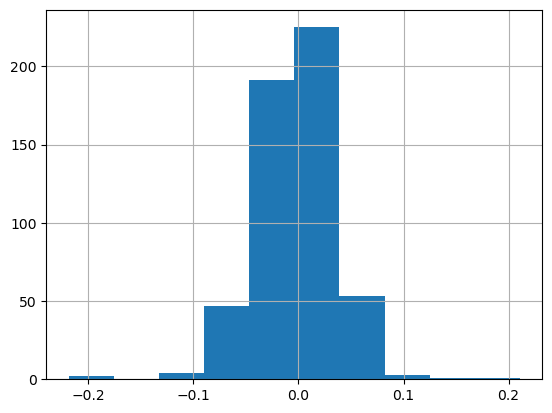

In [30]:
# PCA変換後の各サンプルへの値（PCAは何を表しているのだろう？平均値や中央値のような単純なものではなさそう）
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
df_pca = pd.DataFrame(
    reduced_data, index=df_recurrenced.index, columns=pca.get_feature_names_out()
)
display(df_pca.head())


# 再発期間との相関係数
corr_pca = pd.merge(df_pca, df_MB.RFS_MONTHS, left_index=True, right_index=True).corr()
corr_pca["RFS_MONTHS"].drop("RFS_MONTHS").sort_values(ascending=False).hist()

- pca0ではESR1が最も表されており、DR033780は最も表されていない
- 再発期間との相関係数は低い

### pcaに変換する過程での、遺伝子発現量の寄与度合い（重要さ？）

In [31]:
# 遺伝子→pcaへ変換するための行列の一部（pca0）
# 因子負荷量の絶対値が大きい特徴量ほど、pca後の特徴量をよく表している。
# pcaへの寄与度合？の絶対値順に表示
pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["pca0"].apply(lambda x: abs(x)).sort_values(ascending=False)

Hugo_Symbol
ESR1        7.376479e-02
ANKRD30A    6.209822e-02
AGR3        6.158104e-02
TFF3        6.120205e-02
U79293      6.078438e-02
                ...     
W36271      2.048198e-07
AI673691    1.791555e-07
CCDC54      1.558866e-07
PRSS53      2.485470e-08
DR033780    8.897519e-09
Name: pca0, Length: 24368, dtype: float64

In [32]:
pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["pca1"].apply(lambda x: abs(x)).sort_values(ascending=False)

Hugo_Symbol
AGR3        6.363800e-02
TFF1        5.135283e-02
NAT1        4.983262e-02
TFF3        4.924605e-02
LUM         4.617887e-02
                ...     
CX788685    5.534960e-07
CD160       4.488057e-07
PRMT8       1.417733e-07
AI190388    1.216350e-07
TGFB1       3.514489e-08
Name: pca1, Length: 24368, dtype: float64

PCAによるクラスタリングでは、相関係数上、有力と考えられそうなpca特徴量は見られない  
（元のデータで相関係数が低かった都合上、クラスタリングしても難しいのかもしれない）

## Umap

In [33]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import umap

# 特徴量のセンタリング
df_gene_expressions = df_mrna_agilent_microarray.copy()
df_center = df_recurrenced[df_gene_expressions.columns] - df_recurrenced[
    df_gene_expressions.columns
].mean(axis=0)

# UMAP
reducer = umap.UMAP(random_state=config.SEED)
reducer.fit(df_center)
embedding = reducer.transform(df_center)

plot

In [34]:
import seaborn as sns

plt.figure(figsize=(24, 12))


df_embedding = pd.DataFrame(
    embedding, index=df_recurrenced.index, columns=["umap1", "umap2"]
)

plt.subplot(2, 4, 1)
sns.scatterplot(x="umap1", y="umap2", data=df_embedding)
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection", fontsize=12)

# RFS_MONTHS
targets = ["RFS_MONTHS", "RFS_OVER_{0}MONTHS".format(year * 12)]
for i, target in enumerate(targets):
    plt.subplot(2, 4, i + 2)
    df_plot = pd.merge(
        df_recurrenced[target], df_embedding, right_index=True, left_index=True
    )
    sns.scatterplot(x="umap1", y="umap2", hue=target, data=df_plot)
    plt.gca().set_aspect("equal", "datalim")
    plt.title("UMAP projection ({0})".format(target), fontsize=12)

# カテゴリ変数毎のplot
categories = ["CLAUDIN_SUBTYPE", "NPI_CAT", "TUMOR_CAT", "LYMPH_CAT"]

for i, cat in enumerate(categories):
    df_plot = pd.merge(
        df_recurrenced[cat], df_embedding, right_index=True, left_index=True
    )
    plt.subplot(2, 4, i + 5)
    sns.scatterplot(x="umap1", y="umap2", hue=cat, data=df_plot)
    plt.gca().set_aspect("equal", "datalim")
    plt.title("UMAP projection ({0})".format(cat), fontsize=12)

plt.show()

parameter

In [35]:
def draw_umap(
    target="RFS_MONTHS", n_neighbors=15, min_dist=0.1, metric="euclidean", title=""
):
    # 特徴量のセンタリング
    _df_recurrenced = df_recurrenced.copy()
    _df_gene_expressions = df_mrna_agilent_microarray.copy()
    _df_center = _df_recurrenced[_df_gene_expressions.columns] - _df_recurrenced[
        _df_gene_expressions.columns
    ].mean(axis=0)

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=2,
        metric=metric,
        random_state=config.SEED,
    )
    embedding = reducer.fit_transform(_df_center)
    _df_embedding = pd.DataFrame(embedding, index=_df_recurrenced.index)
    _df_plot = pd.merge(
        _df_recurrenced[target], _df_embedding, right_index=True, left_index=True
    )
    sns.scatterplot(
        x=_df_plot.iloc[:, 1], y=_df_plot.iloc[:, 2], hue=target, data=_df_plot
    )
    plt.title(title, fontsize=18)

/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


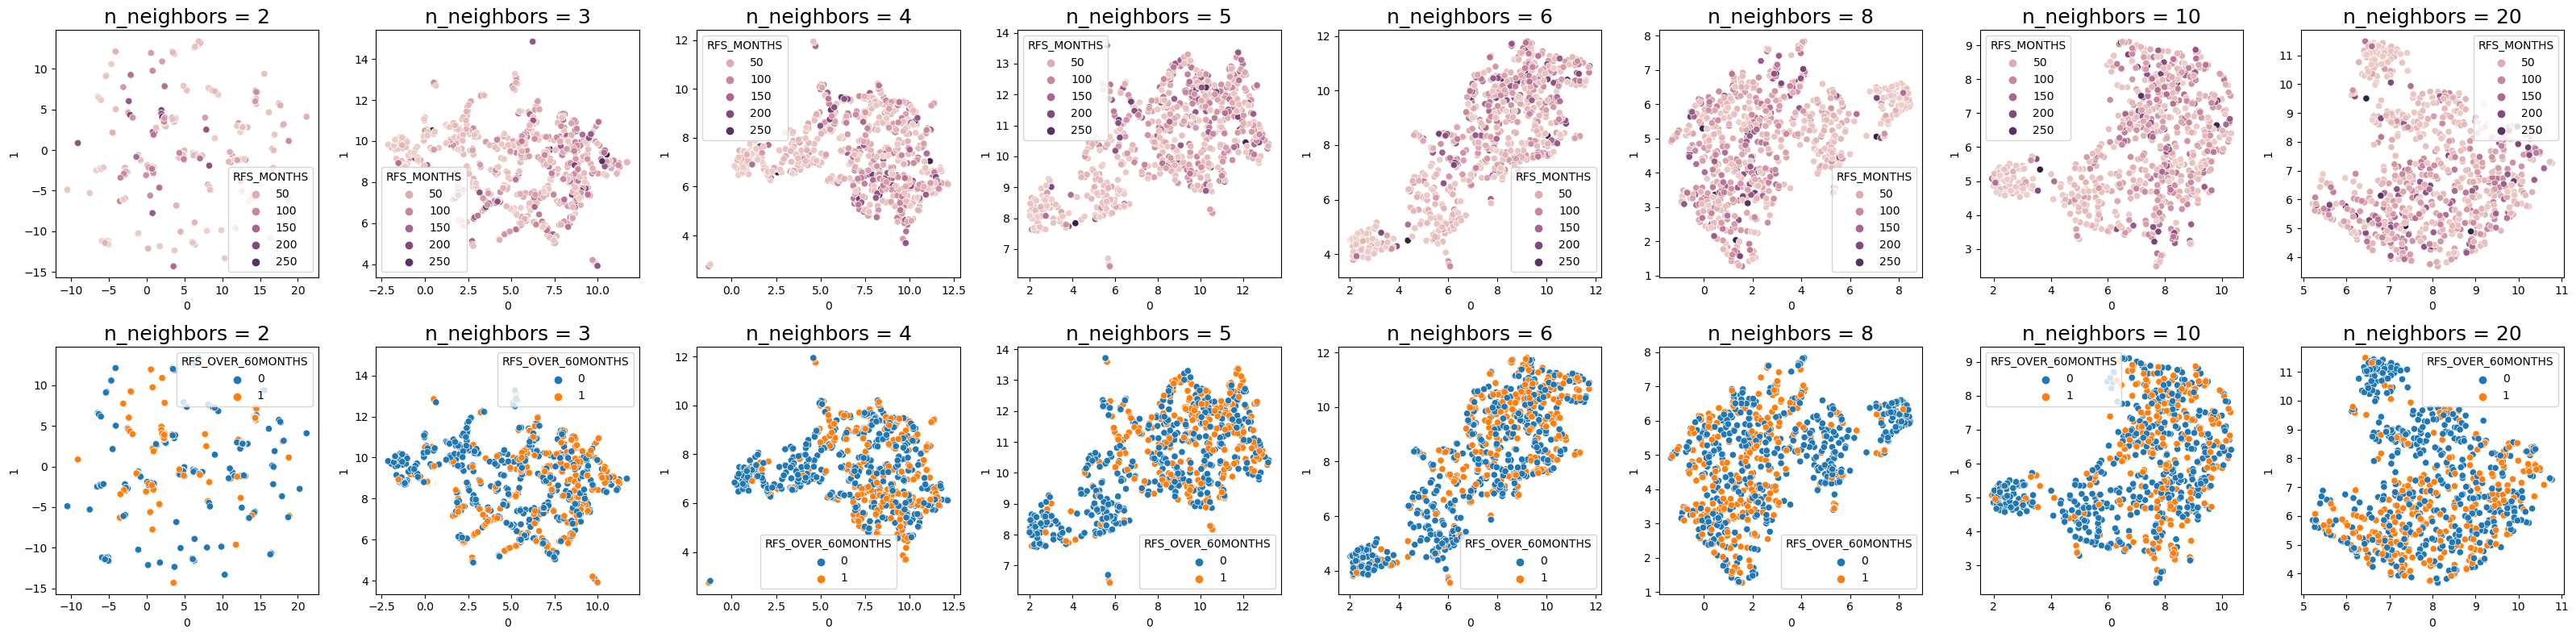

In [36]:
n_neighbors = [2, 3, 4, 5, 6, 8, 10, 20]
plt.figure(figsize=(len(n_neighbors) * 4, 8))
for i, n in enumerate(n_neighbors):
    plt.subplot(2, len(n_neighbors), i + 1)
    draw_umap(target="RFS_MONTHS", n_neighbors=n, title="n_neighbors = {}".format(n))

for i, n in enumerate(n_neighbors):
    plt.subplot(2, len(n_neighbors), i + len(n_neighbors) + 1)
    draw_umap(
        target="RFS_OVER_60MONTHS", n_neighbors=n, title="n_neighbors = {}".format(n)
    )
plt.tight_layout()
plt.show()

In [37]:
min_dists = [0, 0.1, 0.25, 0.5, 0.8, 0.99]

plt.figure(figsize=(len(min_dists) * 4, 8))
for i, d in enumerate(min_dists):
    plt.subplot(2, len(min_dists), i + 1)
    draw_umap(target="RFS_MONTHS", min_dist=d, title="min_dist = {}".format(d))

for i, d in enumerate(min_dists):
    plt.subplot(2, len(min_dists), i + len(min_dists) + 1)
    draw_umap(target="RFS_OVER_60MONTHS", min_dist=d, title="min_dist = {}".format(d))
plt.tight_layout()
plt.show()

In [38]:
# MB-0005を戻してみる
sample = reducer.inverse_transform(np.array([[9.517764, 7.480594]]))

In [69]:
df_tmp = df_center.loc["MB-0005"].T.sort_values()

# np.sort(sample)
# sample = pdDataFrame(sample, columns=df_center.head(1).columns).T
sample = pd.DataFrame(sample).sort_values(by=0)
sample = pd.DataFrame(sample.values, index=df_tmp.index)
pd.merge(df_tmp, sample, right_index=True, left_index=True).sort_values(by="MB-0005")

,MB-0005,0
HLA-A,-3.646267,-0.421876
NPIPL3,-3.287387,-0.378879
U79293,-2.639777,-0.363872
TNK2,-2.474006,-0.362572
ATP6V1B1,-2.404208,-0.358122
...,...,...
ESRRG,4.075908,0.405496
NELL2,4.475684,0.417686
COL4A6,4.497873,0.417789
OLFM4,6.755197,0.419506


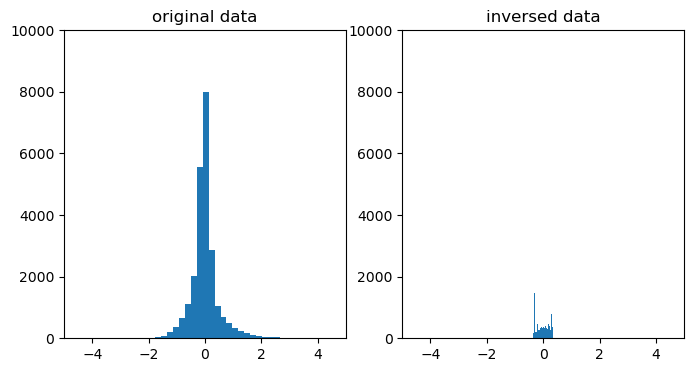

In [127]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.hist(df_tmp, bins=50)
plt.title("original data")
plt.xlim(-5, 5)
plt.ylim(0, 10000)

plt.subplot(1, 2, 2)
plt.hist(sample, bins=50)
plt.title("inversed data")
plt.xlim(-5, 5)
plt.ylim(0, 10000)
plt.show()

# pipelineの練習

In [1]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
import pandas as pd

data = load_wine()

X = pd.DataFrame(data["data"], columns=data["feature_names"])
y = pd.DataFrame(data["target"], columns=["target"])


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA


class StandardScalerAsDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, selector=None):
        self.selector = selector
        self.std = StandardScaler()

    def fit(self, X, y=None):
        self.std.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(self.std.transform(X), index=X.index, columns=X.columns)


class PCAAsDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, selector=None):
        self.selector = selector
        self.pca = PCA(n_components=3, random_state=100)

    def fit(self, X, y=None):
        self.pca.fit(X)
        return self

    def transform(self, X):
        return pd.DataFrame(
            self.pca.transform(X),
            index=X.index,
            columns=self.pca.get_feature_names_out(),
        )

    def show_progress(self, X):
        # 主成分負荷量の計算と表示
        loadings = pd.DataFrame(self.pca.components_.T, index=X.columns)
        # 主成分スコアの計算
        score = pd.DataFrame(self.pca.transform(X), index=X.index)
        # 寄与率:各主成分がどれくらいデータを説明できているのかを表す指標
        contribution_ratios = pd.DataFrame(self.pca.explained_variance_ratio_)
        # 累積寄与率:この寄与率を累積して,ある寄与率に達するまでには第何主成分までが必要かを見ることが多い
        cumulative_contribution_ratios = contribution_ratios.cumsum()
        print(
            "loadings: {0}, score: {1}, 寄与率: {2}, 累積寄与率: {3} ".format(
                loadings, score, contribution_ratios, cumulative_contribution_ratios
            )
        )


# sampling
from imblearn.over_sampling import SMOTE


class SMOTEAsDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, selector=None):
        self.selector = selector
        self.smote = SMOTE(sampling_strategy="minority", random_state=100)

    def fit(self, X, y):
        X, y = self.smote.fit_resample(X, y)
        return self

    def transform(self, X):
        return X


class Echo(BaseEstimator, TransformerMixin):
    def __init__(self, selector=None):
        self.selector = selector

    def fit(self, X, y):
        print("@fit step: ", X.shape, y.shape)
        return self

    def transform(self, X):
        print("@transform step: ", X.shape)
        return X

In [8]:
from imblearn.over_sampling import SMOTE

# from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.neighbors import KNeighborsClassifier


from sklearn import set_config

set_config(display="diagram")
pipe = Pipeline(
    steps=[
        ("echo1", Echo()),
        ("pca", PCA()),
        ("echo2", Echo()),
        ("smote", SMOTE()),
        ("echo3", Echo()),
        ("knn", KNeighborsClassifier()),
    ],
    verbose=True,
)

pipe.fit(X_train, y_train)
huga = pipe.predict(X_test)

@fit step:  (133, 13) (133, 1)
@transform step:  (133, 13)
[Pipeline] ............. (step 1 of 6) Processing echo1, total=   0.0s
[Pipeline] ............... (step 2 of 6) Processing pca, total=   0.0s
@fit step:  (133, 13) (133, 1)
@transform step:  (133, 13)
[Pipeline] ............. (step 3 of 6) Processing echo2, total=   0.0s
[Pipeline] ............. (step 4 of 6) Processing smote, total=   0.0s
@fit step:  (159, 13) (159, 1)
@transform step:  (159, 13)
[Pipeline] ............. (step 5 of 6) Processing echo3, total=   0.0s
[Pipeline] ............... (step 6 of 6) Processing knn, total=   0.0s
@transform step:  (45, 13)
@transform step:  (45, 13)
@transform step:  (45, 13)


/root/miniconda3/envs/breast-cancer-analytics/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


### pipelineからもクラスのメソッドが利用できるかの確認

In [14]:
# 主成分負荷量の計算と表示
loadings = pd.DataFrame(pipe[1].components_.T, index=X.columns)
# 主成分スコアの計算
score = pd.DataFrame(pipe[1].transform(X), index=X.index)
# 寄与率:各主成分がどれくらいデータを説明できているのかを表す指標
contribution_ratios = pd.DataFrame(pipe[1].explained_variance_ratio_)
# 累積寄与率:この寄与率を累積して,ある寄与率に達するまでには第何主成分までが必要かを見ることが多い
cumulative_contribution_ratios = contribution_ratios.cumsum()
print(
    "loadings: {0}, score: {1}, 寄与率: {2}, 累積寄与率: {3} ".format(
        loadings, score, contribution_ratios, cumulative_contribution_ratios
    )
)

loadings:                                     0         1         2         3   \
alcohol                       0.001721 -0.001372 -0.002283  0.135516   
malic_acid                   -0.000851 -0.003131  0.104773  0.217039   
ash                           0.000183  0.003689  0.054626 -0.004425   
alcalinity_of_ash            -0.005298  0.021977  0.971960 -0.215937   
magnesium                     0.018663  0.999485 -0.022850 -0.003761   
total_phenols                 0.001026  0.002008 -0.033933 -0.100810   
flavanoids                    0.001558  0.001418 -0.064217 -0.202913   
nonflavanoid_phenols         -0.000115 -0.001502  0.014199  0.015225   
proanthocyanins               0.000656  0.006206 -0.032008 -0.073150   
color_intensity               0.002259  0.011325  0.177870  0.884148   
hue                           0.000153 -0.000140 -0.019984 -0.068427   
od280/od315_of_diluted_wines  0.000772 -0.001348 -0.047294 -0.211051   
proline                       0.999805 -0.018574  0.00

# scikit-survival の練習

チュートリアル

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

set_config(display="text")  # displays text representation of estimators

In [181]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

iteritems is deprecated and will be removed in a future version. Use .items instead.


In [11]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    Xt, y, test_size=0.25, random_state=random_state
)

In [14]:
rsf = RandomSurvivalForest(
    n_estimators=1000,
    min_samples_split=10,
    min_samples_leaf=15,
    n_jobs=-1,
    random_state=random_state,
)
rsf.fit(X_train, y_train)
rsf.score(X_test, y_test)

0.6759696016771488

実際のデータ

In [36]:
import pandas as pd
from sksurv.ensemble import RandomSurvivalForest

import config

In [74]:
df_MB.THREEGENE.value_counts()

ER+/HER2- Low Prolif     640
ER+/HER2- High Prolif    616
ER-/HER2-                309
HER2+                    198
Name: THREEGENE, dtype: int64

In [97]:
def generate_target():
    # RFS_STATUSのみにnullがあるため、そのデータについては患者データを削除する
    df_MB.dropna(subset=["RFS_STATUS", "RFS_MONTHS"], inplace=True)
    # 予測ラベルを扱いやすい形に変更
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].replace(
        {"1:Recurred": 1, "0:Not Recurred": 0}
    )
    df_MB["RFS_STATUS"] = df_MB["RFS_STATUS"].astype(bool)
    df_MB["RFS_MONTHS"] = df_MB["RFS_MONTHS"].astype(float)


df_MB = pd.read_pickle(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_MB.pkl")
generate_target()

df_gene_expressions = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_gene_expressions.pkl"
)
df_merged = pd.merge(
    df_MB[df_MB.THREEGENE == "HER2+"][["RFS_STATUS", "RFS_MONTHS"]],
    df_gene_expressions,
    right_index=True,
    left_index=True,
)

In [125]:
from sklearn.model_selection import train_test_split

y = df_merged[["RFS_STATUS", "RFS_MONTHS"]]
X = df_merged.drop(["RFS_STATUS", "RFS_MONTHS"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)

In [126]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

std.fit(X_train)
X_train = pd.DataFrame(
    std.transform(X_train), index=X_train.index, columns=X_train.columns
)
X_test = pd.DataFrame(std.transform(X_test), index=X_test.index, columns=X_test.columns)

In [128]:
import time
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=config.SEED)

st = time.time()
pca.fit(X_train)
ed = time.time()
print("fitting time: ", ed - st)
X_train = pd.DataFrame(
    pca.transform(X_train), index=X_train.index, columns=pca.get_feature_names_out()
)
X_test = pd.DataFrame(
    pca.transform(X_test), index=X_test.index, columns=pca.get_feature_names_out()
)

fitting time:  6.955207586288452


In [130]:
rsf = RandomSurvivalForest(
    n_estimators=1000,
    min_samples_split=10,
    min_samples_leaf=15,
    n_jobs=-1,
    random_state=config.SEED,
)
st = time.time()
rsf.fit(X_train, y_train.to_records(index=False))
ed = time.time()
print("fitting time: ", ed - st)

rsf.score(X_test, y_test.to_records(index=False))

fitting time:  54.13320827484131


0.4945717732207479

## 全訓練データ
学習時間：およそ5時間  
スコア：0.5912339789993447
## CLAUDIN_SUBTYPE
### LumA
fitting time:  1240.5047543048859  
0.46822397801442805

### LumB
fitting time:  524.0930061340332  
0.5616502578527895

### Her2
fitting time:  77.8102433681488  
0.5042826552462527

fitting time:  58.654019355773926  
0.621031746031746

## THREEGENES
### ER+/HER2- Low Prolif
fitting time:  1018.359384059906  
0.5607091321377036

### ER+/HER2- High Prolif
fitting time:  946.286304473877   
0.5472560975609756

### ER-/HER2-
fitting time:  149.6308627128601  
0.45369705671213206

### HER2+
fitting time:  53.25194692611694  
0.4945717732207479

In [132]:
from sklearn.metrics import mean_squared_error

y_pred = rsf.predict(X_train)
display(mean_squared_error(y_train.RFS_MONTHS, y_pred, squared=False))

y_pred = rsf.predict(X_test)
display(mean_squared_error(y_test.RFS_MONTHS, y_pred, squared=False))

102.48115738034521

105.03961162976738

<AxesSubplot: >

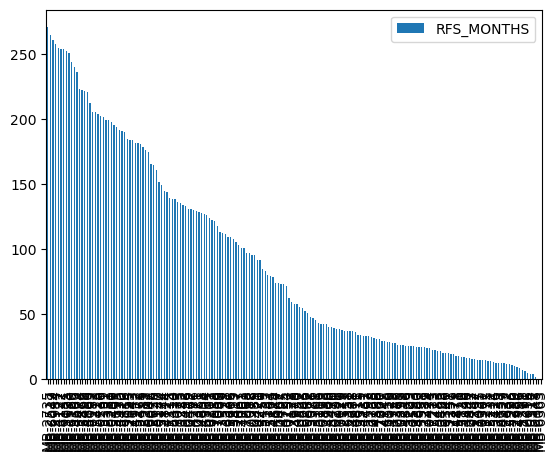

In [142]:
y.sort_values("RFS_MONTHS", ascending=False).plot.bar()

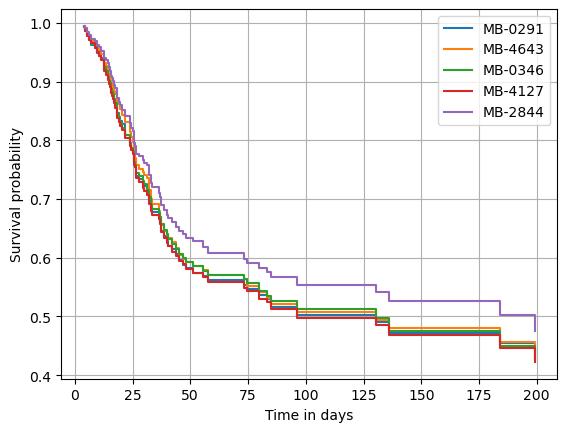

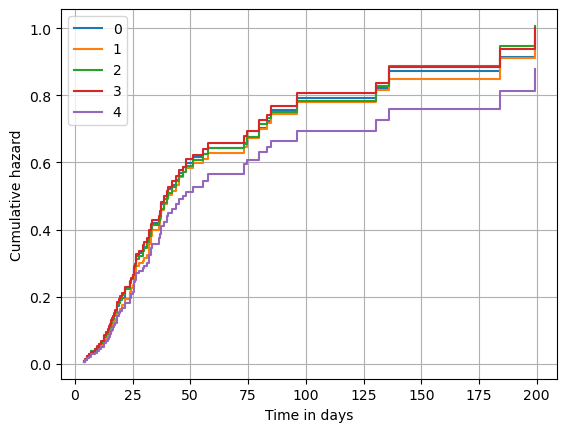

In [136]:
# 患者ごとの生存関数（非再発）
surv = rsf.predict_survival_function(X_test.head(), return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend(X_test.index)
plt.grid(True)
plt.show()

# 患者ごとのハザード関数（再発）
surv = rsf.predict_cumulative_hazard_function(X_test.head(), return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend(X_test.index)
plt.grid(True)
plt.show()

In [165]:
y_test.head().RFS_MONTHS.dtype

dtype('float64')

shapが使用できるか確認

https://github.com/sebp/scikit-survival/discussions/213



In [169]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
explainer = shap.Explainer(rsf.predict, X_test, feature_names=X_test.columns)
shap_values = explainer(X_test.head())

Permutation explainer: 6it [00:35,  7.14s/it]                                            


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


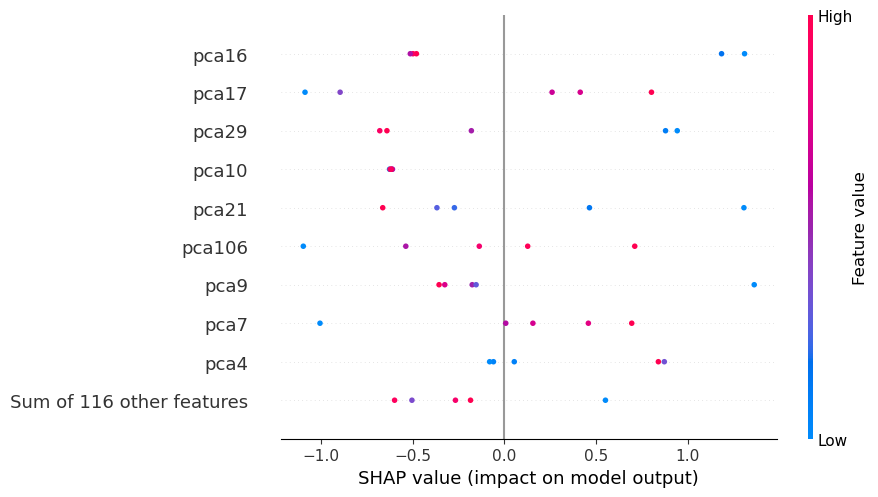

In [172]:
shap.plots.beeswarm(shap_values)

In [184]:
y_test.to_records(index=False)

rec.array([( True,  38.68), ( True,  24.74), ( True,  20.16),
           (False, 254.77), (False, 144.8 ), (False, 107.57),
           (False, 181.97), (False, 101.35), ( True,  25.3 ),
           (False, 139.87), ( True,  28.75), ( True,   0.  ),
           ( True,  33.78), (False, 127.53), ( True,   0.36),
           ( True,  12.53), ( True,  12.73), ( True,  74.18),
           ( True,  39.31), ( True,  12.01), ( True,  37.2 ),
           ( True,  91.78), (False,  96.97), ( True,  14.93),
           (False, 181.84), (False, 161.38), (False,  38.06),
           (False, 254.28), ( True,  10.72), (False, 222.2 ),
           ( True, 122.34), (False,  52.2 ), ( True,  13.95),
           (False, 131.02), ( True,  22.63), ( True,  28.75),
           (False, 260.76), ( True, 165.07), ( True, 194.28),
           (False, 127.63), ( True,  22.5 ), (False, 131.02),
           ( True,  73.06), (False, 165.99), ( True,  15.13),
           (False, 223.72), (False, 190.59)],
          dtype=[('RFS_S

In [183]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rsf, n_iter=15, random_state=config.SEED)
perm.fit(X_test, y_test.to_records(index=False))
eli5.show_weights(perm)

Weight,Feature
0.0179 ± 0.0432,x21
0.0138 ± 0.0328,x29
0.0123 ± 0.0178,x102
0.0079 ± 0.0407,x7
0.0077 ± 0.0091,x68
0.0060 ± 0.0048,x122
0.0056 ± 0.0061,x1
0.0051 ± 0.0094,x5
0.0047 ± 0.0053,x88
0.0044 ± 0.0040,x84
